In [27]:
import os

import numpy as np
import numpy.ma as ma
import geopandas as gpd

import rasterio
import rasterio.plot
from rasterio.enums import Resampling
from shapely.geometry.point import Point

from matplotlib import pyplot as plt
from matplotlib.path import Path
from matplotlib_scalebar.scalebar import ScaleBar

import contextily as cx
from tqdm import tqdm

import IR_processing_utils

plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['font.size'] = 7





In [28]:
path2areas = r'D:\!Work\! Projects\2024- Плейстоценовый парк\ploshadki\ploshadki_park.shp'



# path2IR_rasters = [r"G:\! Data\IFA\! campaigns\202404 Pleistocene Park\IR_mavic3\geotiffs\DJI_202404210937_006_Pleystocen-IR_t3dt.tif",
#                    r"G:\! Data\IFA\! campaigns\202404 Pleistocene Park\IR_mavic3\geotiffs\DJI_202404211121_009_Pleystocen-IRb_t3dt.tif",
#                    r"G:\! Data\IFA\! campaigns\202404 Pleistocene Park\IR_mavic3\geotiffs\DJI_202404221002_011_Pleystocen-IR3.tif",
#                    r"G:\! Data\IFA\! campaigns\202404 Pleistocene Park\IR_mavic3\geotiffs\DJI_202404221002_011_Pleystocen-IR3_t3dt.tif",
#                    r"G:\! Data\IFA\! campaigns\202404 Pleistocene Park\IR_mavic3\geotiffs\DJI_202404221218_016_Pleystocen-IR3b.tif",
#                    r"G:\! Data\IFA\! campaigns\202404 Pleistocene Park\IR_mavic3\geotiffs\DJI_202404221218_016_Pleystocen-IR3b_t3dt.tif"]

# path2IR_rasters = [r"G:\! Data\IFA\! campaigns\202404 Pleistocene Park\IR_mavic3\geotiffs_new\DJI_202404210937_006_Pleystocen-IR_emis1_L3dt_geocorr.tif",
#                    r"G:\! Data\IFA\! campaigns\202404 Pleistocene Park\IR_mavic3\geotiffs_new\DJI_202404211121_009_Pleystocen-IRb_emis1_L3dt_geocorr.tif",
#                    r"G:\! Data\IFA\! campaigns\202404 Pleistocene Park\IR_mavic3\geotiffs_new\DJI_202404221002_011_Pleystocen-IR3_emis1_L3dt_geocorr.tif",
#                    r"G:\! Data\IFA\! campaigns\202404 Pleistocene Park\IR_mavic3\geotiffs_new\DJI_202404221218_016_Pleystocen-IR3b_emis1_L3dt_geocorr.tif",
#                    r"G:\! Data\IFA\! campaigns\202404 Pleistocene Park\IR_mavic3\geotiffs_new\DJI_202404231239_024_Pleystocen-IR3_emis1_L3dt_geocorr.tif"]

path2IR_rasters = [r'G:\! Data\IFA\! campaigns\202404 Pleistocene Park\IR_mavic3\geotiffs_new\DJI_202404230843_017_Pleystocen-IR5_emis1_L3dt_geocorr.tif']


polygons = gpd.read_file (path2areas)
polygons['coords'] = polygons['geometry'].apply(lambda x: x.representative_point().coords[:])
polygons['coords'] = [coords[0] for coords in polygons['coords']]
polygons['extent'] = [[p.bounds[0], p.bounds[2], p.bounds[1], p.bounds[3]] for p in polygons['geometry']]



In [29]:


rasters = []

for path in path2IR_rasters:

    raster = {}

    display(path)

    src = rasterio.open(path)
    
    data = src.read() 
    values = data [0,:,:]
    mask = data [1,:,:]

    n = np.sum (mask > 0)
    display(n)
    

    raster['fname'] = os.path.basename(path)
    raster['values'] = ma.masked_array(values, ~mask.astype(bool))
    raster['extent'] = (src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top)
    raster['lons'], raster['lats'] =  IR_processing_utils.get_subarray_coords_rio (values.shape, src.crs, src.transform)
    raster['vmin2draw'] = np.nanpercentile(raster['values'].copy().filled(np.nan).flatten(), 1)
    raster['vmax2draw'] = np.nanpercentile(raster['values'].copy().filled(np.nan).flatten(), 99) #np.percentile(np.copy(raster['values'].flatten()), 99)
    rasters.append(raster)
    #break

'G:\\! Data\\IFA\\! campaigns\\202404 Pleistocene Park\\IR_mavic3\\geotiffs_new\\DJI_202404230843_017_Pleystocen-IR5_emis1_L3dt_geocorr.tif'

21036372

In [30]:


# rasters = []

# for path in path2IR_rasters:

#     raster = {}

#     display(path)

#     src = rasterio.open(path)
    
#     data = src.read() 
#     values = data [0,:,:]
#     mask = data [1,:,:]
#     raster['fname'] = os.path.basename(path)
#     raster['values'] = ma.masked_array(values, ~mask.astype(bool))
#     raster['extent'] = (src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top)
#     raster['lons'], raster['lats'] =  get_subarray_coords_rio (values.shape, src.crs, src.transform)
#     raster['vmin2draw'] = np.nanpercentile(raster['values'].copy().filled(np.nan).flatten(), 1)
#     raster['vmax2draw'] = np.nanpercentile(raster['values'].copy().filled(np.nan).flatten(), 99) #np.percentile(np.copy(raster['values'].flatten()), 99)
#     rasters.append(raster)
#     #break

In [31]:
min_lon = np.min([r['extent'][0] for r in rasters])
max_lon = np.max([r['extent'][1] for r in rasters])
min_lat = np.min([r['extent'][2] for r in rasters])
max_lat = np.max([r['extent'][3] for r in rasters])

ir_lon_lim = np.array([min_lon - 0.01 * (max_lon - min_lon), max_lon + 0.01 * (max_lon - min_lon)])
ir_lat_lim = np.array([min_lat - 0.01 * (max_lat - min_lat), max_lat + 0.01 * (max_lat - min_lat)])



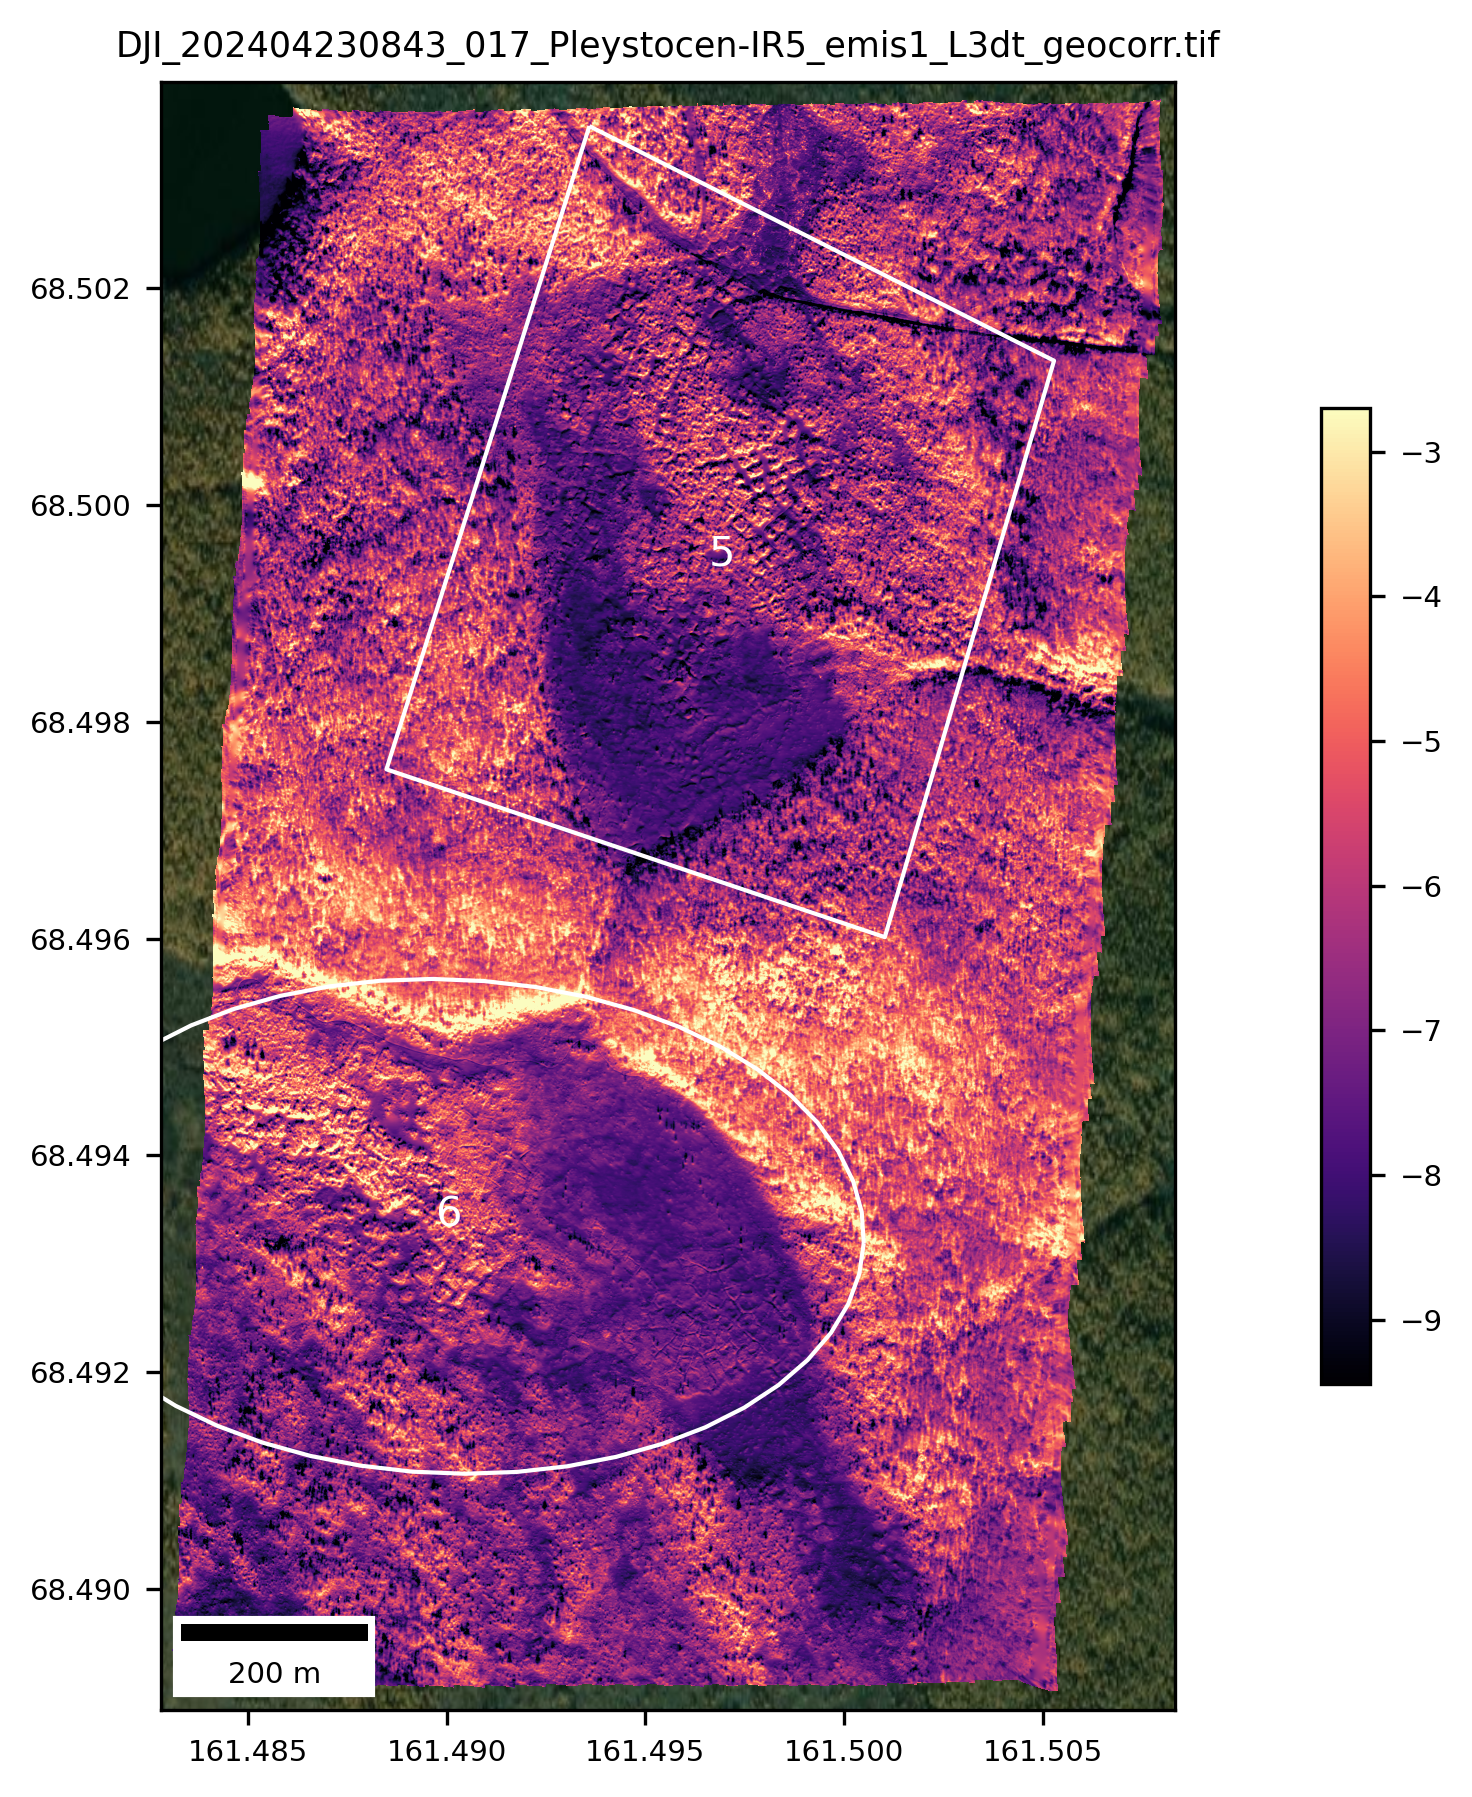

In [32]:
pics_dir = 'pics_IR'
if not os.path.isdir (pics_dir):
    os.mkdir(pics_dir)


for i, raster in enumerate (rasters):
    plt.figure(figsize = (10, 6))
    plt.xlim(ir_lon_lim)
    plt.ylim(ir_lat_lim)
    cx.add_basemap(plt.gca(), source = cx.providers.Esri.WorldImagery, crs = 4326, attribution_size = 2, attribution = '')              
    
    im = plt.imshow (raster['values'], extent= raster['extent'], vmin=raster['vmin2draw'], vmax=raster['vmax2draw'], cmap = 'magma')
    polygons.plot (edgecolor = 'white', facecolor = 'None', ax = plt.gca())
    for idx, row in polygons.iterrows():
        plt.annotate(text=str(idx+1), xy=row['coords'],
                    horizontalalignment='center', fontsize = 10, color = 'white')
    
    points = gpd.GeoSeries([Point(161, ir_lat_lim.mean()), Point(162, ir_lat_lim.mean())], crs=4326)  # Geographic WGS 84 - degrees
    points = points.to_crs(32619)
    distance_meters = points[0].distance(points[1])

    scalebar = ScaleBar(distance_meters, length_fraction=0.25, location = 'lower left', pad = 0.2, border_pad = 0.5) #, units = "km", )
    plt.gca().add_artist(scalebar)                     

    plt.title(raster['fname'])
    plt.colorbar(im, shrink = 0.6)
    plt.tight_layout()
    plt.savefig (pics_dir + '/' + raster['fname'] + '.png')
    #break
#plt.gca().set_aspect(1.0/np.cos(lats.mean()*np.pi/180))

C:\Users\mvar9\AppData\Local\Temp\ipykernel_8280\3152198524.py:27: RuntimeWarning: Mean of empty slice
  cur_raster_stats['t_mean' + str(idx+1)] = np.nanmean (cur_temp.flatten())
c:\Anaconda\envs\GIS\Lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


{'fname': 'DJI_202404230843_017_Pleystocen-IR5_emis1_L3dt_geocorr.tif',
 't_mean1': nan,
 't_std1': nan,
 't_mean2': nan,
 't_std2': nan,
 't_mean3': nan,
 't_std3': nan,
 't_mean4': nan,
 't_std4': nan,
 't_mean5': -6.823392,
 't_std5': 1.402765,
 't_mean6': -6.4820757,
 't_std6': 1.5004929}

c:\Anaconda\envs\GIS\Lib\site-packages\numpy\lib\histograms.py:885: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


fname  t_mean1  t_std1  \
0  DJI_202404230843_017_Pleystocen-IR5_emis1_L3dt...      NaN     NaN   

   t_mean2  t_std2  t_mean3  t_std3  t_mean4  t_std4   t_mean5    t_std5  \
0      NaN     NaN      NaN     NaN      NaN     NaN -6.823392  1.402765   

    t_mean6    t_std6  
0 -6.482076  1.500493

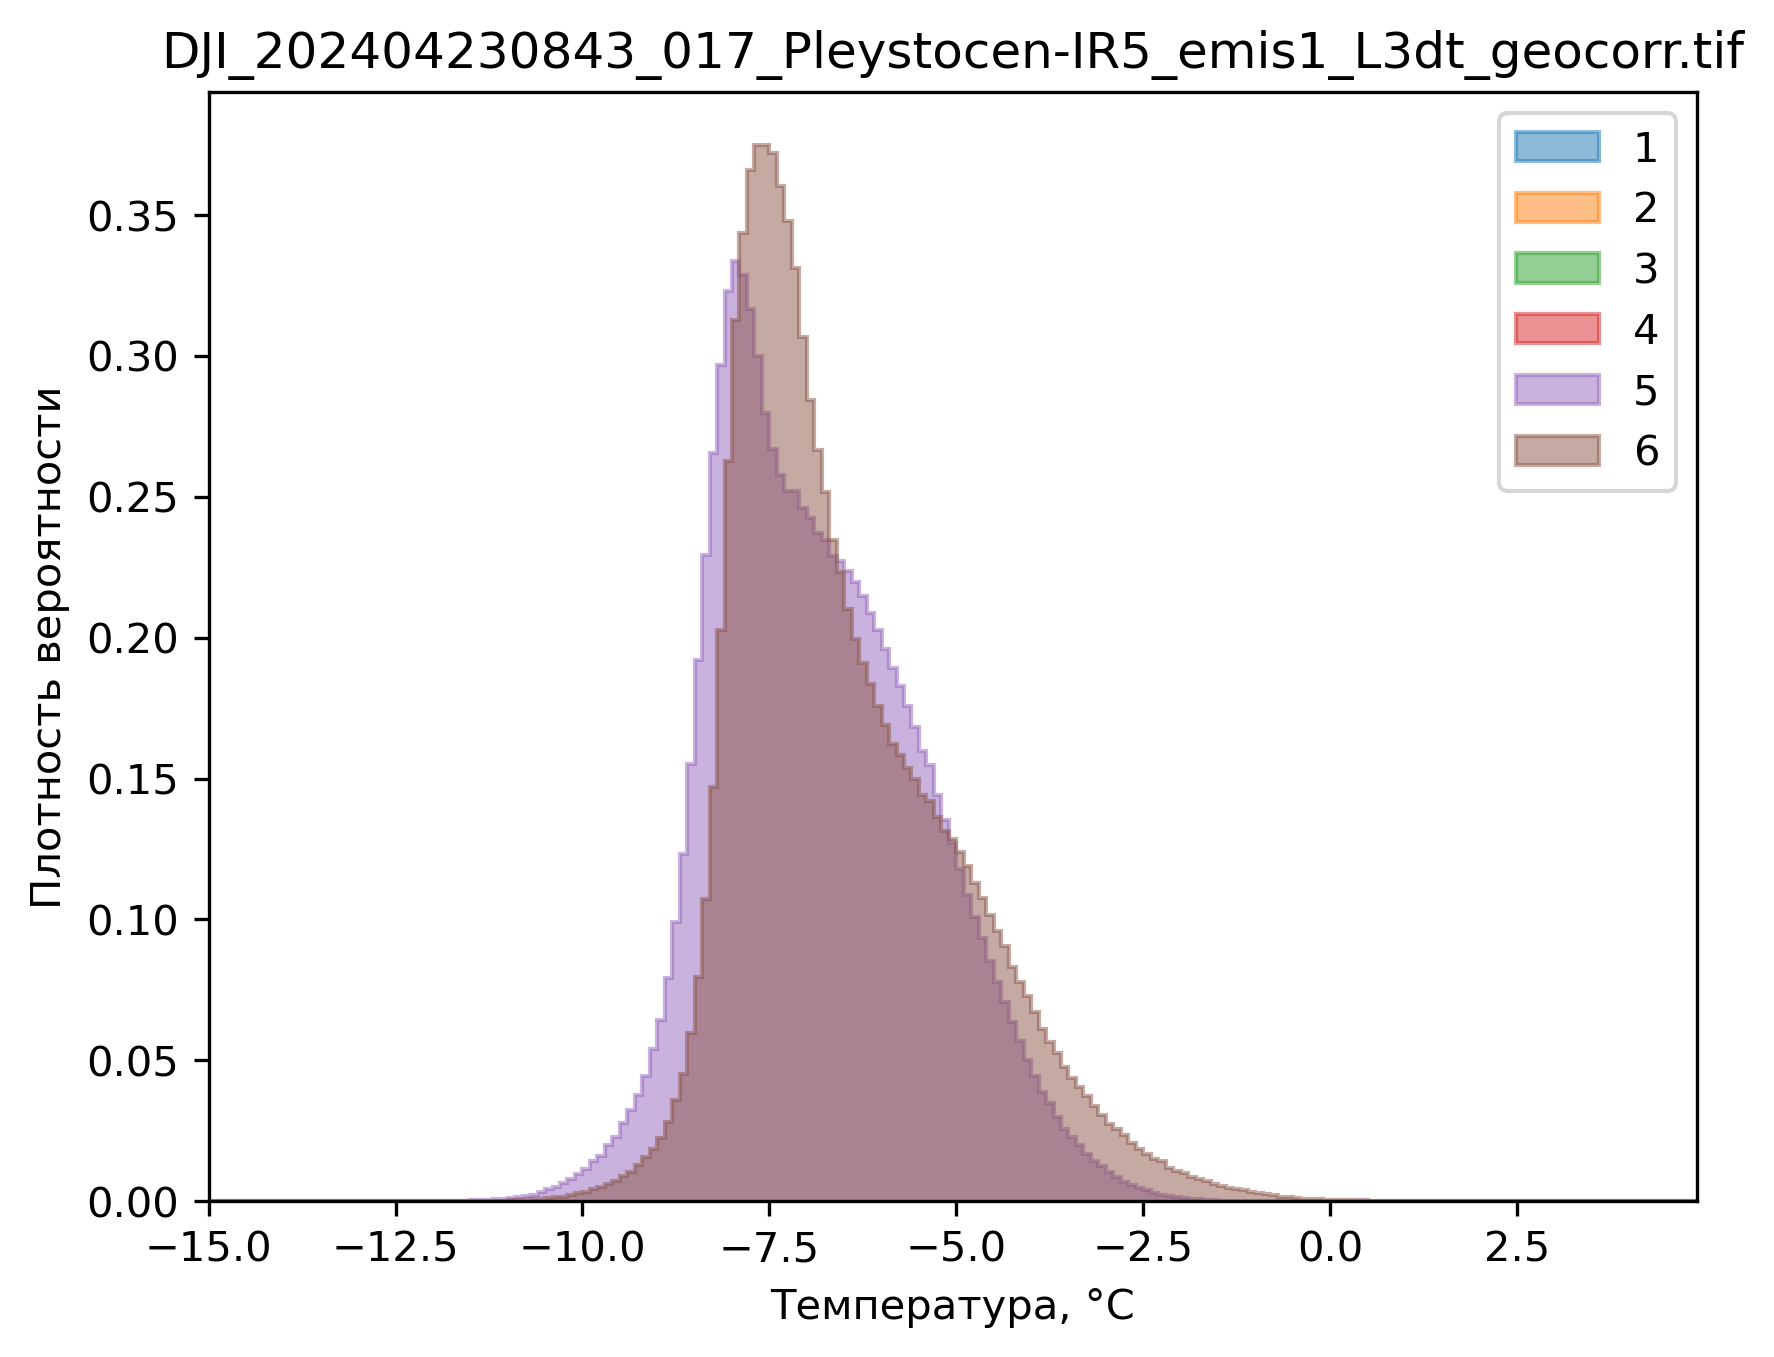

In [33]:
import pandas as pd
plt.rcParams['font.size'] = 10

hist_bins = np.arange(-15,5, 0.1)

polygon_stats = pd.DataFrame()
for i_r, raster in enumerate (rasters):
    cur_raster_stats = {}
    cur_raster_stats['fname'] = raster['fname']
    temp4polygons = {}
    #for polygon in polygons:
    for idx, row in polygons.iterrows():
        polygon = polygons['geometry'][idx]
        mpath = Path(np.transpose(polygon.exterior.xy)) # the vertices of the polygon
        #x_mesh, y_mesh = np.meshgrid(raster['lons'], raster['lats'])
        xy_mesh = np.dstack((raster['lons'], raster['lats']))
        xy_mesh_flat = xy_mesh.reshape((-1, 2))

        polygon_mask = mpath.contains_points(xy_mesh_flat).reshape(raster['values'].shape)
        
        
        cur_temp = raster['values'].copy()
        cur_temp = raster['values'].filled(np.nan)
        cur_temp[~polygon_mask] = np.nan
        temp4polygons['t'+ str(idx+1)] = cur_temp[~np.isnan(cur_temp)]

        cur_raster_stats['t_mean' + str(idx+1)] = np.nanmean (cur_temp.flatten())
        cur_raster_stats['t_std' + str(idx+1)] = np.nanstd (cur_temp.flatten())
        
        #plt.figure()
        #im = plt.imshow (test, extent= raster['extent']) 
    display(cur_raster_stats)
    #sys.exit()
    polygon_stats = pd.concat((polygon_stats, pd.DataFrame(cur_raster_stats, index = [i_r])),axis=0)
    plt.figure()
    for key in temp4polygons.keys():
        plt.hist(temp4polygons[key], bins=hist_bins, density=True, histtype='step', label=key.replace('t', ''), fill = True, alpha=0.5)
    
    plt.xlim([hist_bins.min(), hist_bins.max()])
    plt.ylabel('Плотность вероятности')#, fontsize='medium')
    plt.xlabel('Температура, °C')#, fontsize='medium')
    plt.legend()#fontsize='medium')
    plt.title(raster['fname'])#, fontsize='medium')
    plt.savefig (pics_dir + '/' + 'hists_' + raster['fname'] + '.png')
display(polygon_stats)


In [34]:
polygon_stats.to_csv ('polygon_stats1.csv', sep = ';')

In [35]:
(polygon_stats['t_std1'] - polygon_stats['t_std2'])/ polygon_stats['t_std2']

0   NaN
dtype: float32